In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sympy import Symbol, symbols, solve, lambdify
from sympy import init_printing
init_printing()
#observables
n1, n2 =  symbols('n1 n2')
#parameters
s1, s2, b1, b2, mu =  symbols('s1 s2 b1 b2 mu')
#helpers
(n1, n2) =  symbols('n1 n2')
#estimators
muhat = symbols('muhat')

nu1 = muhat*s1+b1
nu2 = muhat*s2+b2

#solve for L'=0
[expr1, expr2] = solve( s1+s2 - n1*s1/nu1 - n2*s2/nu2, muhat)

muhatFunc = lambdify((n1,n2,b1,b2,s1,s2),expr2,"numpy")
#test if that works
muhatFunc(10,10,5,5,5,5),muhatFunc(15,25,5,15,5,5)

In [34]:
s1,s2 = 10,20
b1,b2 = 50, 100

nus = (nu1b, nu1sb, nu2b, nu2sb) = (b1,s1+b1,b2,s2+b2)

nexpts = 100000
toys = b_n1, sb_n1, b_n2, sb_n2 = [np.random.poisson(nu,nexpts) for nu in nus]

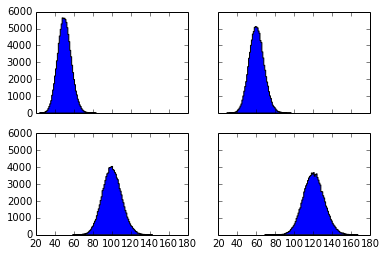

In [35]:
plt.clf()
fig, ax = plt.subplots(2,2, sharey = True, sharex = True)
for i,t in enumerate(toys):
    ax[i/2,i%2].hist(t, bins = sorted(list(set(t))), histtype ='stepfilled')

In [36]:
def lambda0(muhat,n,b,s):
    return 2*(-muhat*s + n*np.log(1+(muhat*s)/b))

def q0_twoBin_DGSS(n1,n2,b1,b2,s1,s2):
    muhat = muhatFunc(n1,n2,b1,b2,s1,s2)
    q1 = lambda0(muhat,n1,b1,s1)
    q2 = lambda0(muhat,n2,b2,s2)
    return q1+q2

In [37]:
def get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2):
    sb_q0, b_q0 = [q0_twoBin_DGSS(n1,n2,b1,b2,s1,s2) for n1,n2 in [(sb_n1,sb_n2), (b_n1,b_n2)]]

    b_histo,b,_ = plt.hist(b_q0, bins = 100, alpha = 0.5, color = 'b')
    sb_histo,b,_ = plt.hist(sb_q0, bins = b, alpha = 0.5, color = 'r')

    integral_b = 1-np.cumsum(b_histo)/np.sum(b_histo)
    integral_sb = 1-np.cumsum(sb_histo)/np.sum(sb_histo)
    return integral_b,integral_sb

In [38]:
run1_nexpts = 10000
run1_toys = b_n1_run1, sb_n1_run1, b_n2_run1, sb_n2_run1 = [np.random.poisson(nu,nexpts) for nu in nus]




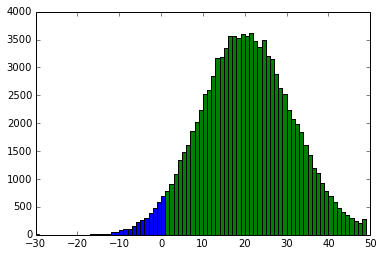

In [39]:
s1_run1 = sb_n1_run1-b1
s2_run1 = sb_n2_run1-b2
run_1_s = np.vstack((s1_run1,s2_run1)).T

s1gt0 = run_1_s[run_1_s[:,0]>0]
s2gt0 = run_1_s[run_1_s[:,1]>0]

bothgt0 = s1gt0[s1gt0[:,1]>0]

filtered_run1_n1 = bothgt0.T[0]
filtered_run1_n2 = bothgt0.T[1]
plt.clf()
c,b,_ = plt.hist(s2_run1, bins = range(-30,50))
c,b,_ = plt.hist(s2gt0.T[1], bins = b)

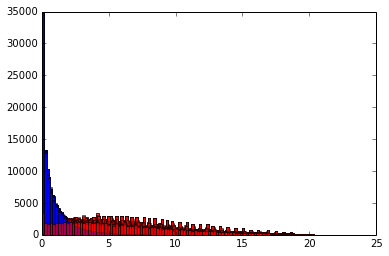

In [59]:
rocdata_run1toys = [get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2) for s1,s2 in zip(filtered_run1_n1,filtered_run1_n2)[0:500]]

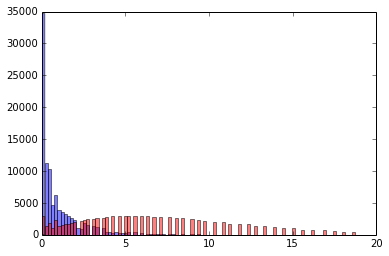

In [60]:
s1,s2 = 10,20
rocdata_truth = get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2)

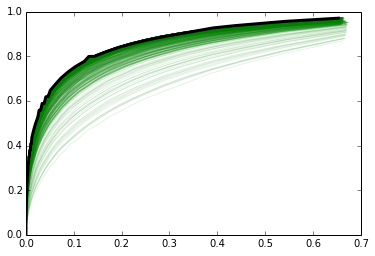

In [98]:
def rocfunc(rocdata):
    a = zip(rocdata[0],rocdata_truth[1])
    sorted_a = sorted(a,key = lambda x:x[0])
    back = zip(*sorted_a)
    def roc(x):
        return np.interp(x,back[0],back[1])
    return roc
    

In [111]:
rocfuncs = [rocfunc(rocdata) for rocdata in rocdata_run1toys]
rocslices = [(x,[roc(x) for roc in rocfuncs]) for x in np.logspace(-5,0,1000)]

means = [(x,np.mean(slic)) for x,slic in rocslices]

740


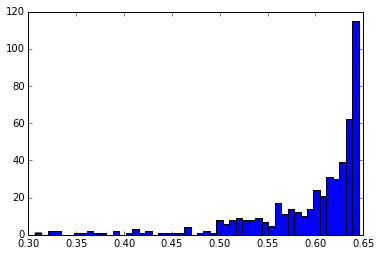

In [118]:
#take a vertical slice on the 0.05 point

index = next(i for i,(x,l) in enumerate(rocslices) if x>0.05)
print index
plt.clf()
h = plt.hist(rocslices[index][1], bins = 50)
means[index]

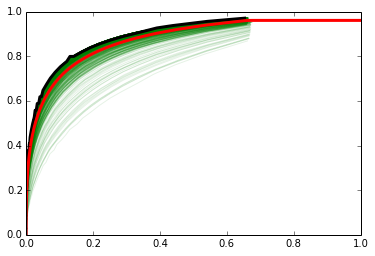

In [119]:
plt.clf()
plt.figure()
#plt.loglog()
for rocdata in rocdata_run1toys:
    plt.plot(*rocdata, lw = 1, alpha = 0.1, color = 'green')

plt.plot(*rocdata_truth, lw = 3, color = 'black')
plt.plot(*zip(*means), lw = 3, color = 'red')

In [168]:
import scipy.stats

In [187]:
def sijpdf(nu1,nu2):
    p1 = scipy.stats.poisson(mu = nu1)
    p2 = scipy.stats.poisson(mu = nu2)
    def pdf(x1,x2):
        return p1.pmf(x1) * p2.pmf(x2)
    return pdf

In [189]:
pdf = sijpdf(10,10)

In [190]:
pdf(1,4)

In [201]:
rocdata_truth[0][1]